In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm4/BMIdata.csv')
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [3]:
data['Index'].unique()

array([4, 2, 3, 5, 1, 0])

In [4]:
type(data['Height'].values)

numpy.ndarray

In [5]:
data['obese'] = (data.Index >= 4).astype('int')
data.drop('Index', axis = 1, inplace = True)

In [6]:
data.head()

,Gender,Height,Weight,obese
0,Male,174,96,1
1,Male,189,87,0
2,Female,185,110,1
3,Female,195,104,0
4,Male,149,61,0


In [7]:
print(" Misclassified when cutting at 100kg:", data.loc[(data['Weight']>=100) & (data['obese']==0),:].shape[0], "\n", "Misclassified when cutting at 80kg:", data.loc[(data['Weight']>=80) & (data['obese']==0),:].shape[0])

 Misclassified when cutting at 100kg: 18 
 Misclassified when cutting at 80kg: 63


<h2>entropi</h2>

In [8]:
def entropy(y):
    '''
    Given a Pandas Series, it calculates the entropy.
    y: variable with which calculate entropy.
    '''
    if isinstance(y, pd.Series):
        a = y.value_counts()/y.shape[0]
        entropy = np.sum(-a*np.log2(a+1e-9))
        return(entropy)
    else:
        raise('Object must be a Pandas Series.')

entropy(data.Gender)

np.float64(0.9997114388674198)

<h2>indeks gini</h2>

In [9]:
def gini_impurity(y):
    '''
    Given a Pandas Series, it calculates the Gini Impurity.
    y: variable with which calculate Gini Impurity.
    '''
    if isinstance(y, pd.Series):
        p = y.value_counts()/y.shape[0]
        gini = 1-np.sum(p**2)
        return(gini)
    else:
        raise('Object must be a Pandas Series.')

gini_impurity(data.Gender)

np.float64(0.4998)

<h2>Information gain</h2>

In [10]:
def variance(y):
    '''
    Function to help calculate the variance avoiding nan.
    y: variable to calculate variance to. It should be a Pandas Series.
    '''
    if(len(y) == 1):
        return 0
    else:
        return y.var()
        
def information_gain(y, mask, func=gini_impurity):
    '''
    It returns the Information Gain of a variable given a loss function.
    y: target variable.
    mask: split choice.
    func: function to be used to calculate Information Gain in case os
    classification.
    '''
    a = sum(mask)
    b = mask.shape[0] - a
    if(a == 0 or b ==0):
        ig = 0
    else:
        if y.dtypes != 'O':
            ig = variance(y) - (a/(a+b)* variance(y[mask])) -(b/(a+b)*variance(y[-mask]))
        else:
            ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
    return ig

<h2>Cara Menentukan Pemisahan Terbaik dari sebuah Variabel</h2>

In [11]:
import itertools
def categorical_options(a):
    '''
    Creates all possible combinations from a Pandas Series.
    a: Pandas Series from where to get all possible combinations.
    '''
    a = a.unique()
    opt = []
    for L in range(0, len(a)+1):
        for subset in itertools.combinations(a, L):
            subset = list(subset)
            opt.append(subset)
    return opt[1:-1]

In [12]:
def max_information_gain_split(x, y, func=gini_impurity):
    '''
    Given a predictor & target variable, returns the best split, the error and the
    type of variable based on a selected cost function.
    x: predictor variable as Pandas Series.
    y: target variable as Pandas Series.
    func: function to be used to calculate the best split.
    '''
    split_value = []
    ig = []
    numeric_variable = True if x.dtypes != 'O' else False
    
    # Create options according to variable type
    if numeric_variable:
        options = x.sort_values().unique()[1:]
    else:
        options = categorical_options(x)
        
    # Calculate ig for all values
    for val in options:
        mask = x < val if numeric_variable else x.isin(val)
        val_ig = information_gain(y, mask, func)
        # Append results
        ig.append(val_ig)
        split_value.append(val)
        
    # Check if there are more than 1 results if not, return False
    if len(ig) == 0:
        return(None,None,None, False)
    else:
        # Get results with highest IG
        best_ig = max(ig)
        best_ig_index = ig.index(best_ig)
        best_split = split_value[best_ig_index]
        return(best_ig,best_split,numeric_variable, True)

In [13]:
weight_ig, weight_split, _, _ = max_information_gain_split(data['Weight'],data['obese'])
print("The best split for Weight is when the variable is less than ",weight_split,"\nInformation Gain for that split is:", weight_ig)

The best split for Weight is when the variable is less than  103 
Information Gain for that split is: 0.10625190497954967


<h2>Cara Memilih Pemisahan Terbaik</h2>

In [14]:
data.drop('obese', axis= 1).apply(max_information_gain_split, y = data['obese'])

,Gender,Height,Weight
0,-0.000281,0.019684,0.106252
1,[Male],174,103
2,False,True,True
3,True,True,True


<h2>Cara Melatih Decision Tree dengan Python dari Awal
</h2>

<h3>1. Menentukan Kedalaman Pohon
</h3>

In [15]:
def get_best_split(y, data):
    '''
    Given a data, select the best split and return the variable, the value, the
    variable type and the information gain.
    y: name of the target variable
    data: dataframe where to find the best split.
    '''
    masks = data.drop(y, axis= 1).apply(max_information_gain_split, y = data[y])
    if sum(masks.loc[3,:]) == 0:
        return(None, None, None, None)
    else:
        # Get only masks that can be splitted
        masks = masks.loc[:,masks.loc[3,:]]
        
        # Get the results for split with highest IG
        split_variable = masks.iloc[0].astype(np.float32).idxmax()
        
        #split_valid = masks[split_variable][]
        split_value = masks[split_variable][1]
        split_ig = masks[split_variable][0]
        split_numeric = masks[split_variable][2]
        
        return(split_variable, split_value, split_ig, split_numeric)

In [16]:
def make_split(variable, value, data, is_numeric):
    '''
    Given a data and a split conditions, do the split.
    variable: variable with which make the split.
    value: value of the variable to make the split.
    data: data to be splitted.
    is_numeric: boolean considering if the variable to be splitted is numeric or
    not.
    '''
    if is_numeric:
        data_1 = data[data[variable] < value]
        data_2 = data[(data[variable] < value) == False]
    else:
        data_1 = data[data[variable].isin(value)]
        data_2 = data[(data[variable].isin(value)) == False]
    return(data_1,data_2)

In [17]:
def make_prediction(data, target_factor):
    '''
    Given the target variable, make a prediction.
    data: pandas series for target variable
    target_factor: boolean considering if the variable is a factor or not
    '''
    # Make predictions
    if target_factor:
        pred = data.value_counts().idxmax()
    else:
        pred = data.mean()
    return pred

<h3>2. Melatih Decision Tree dengan Python
</h3>

In [18]:
def train_tree(data,y, target_factor, max_depth = None,min_samples_split = None,min_information_gain = 1e-20, counter=0, max_categories = 20):
    '''
    Trains a Decission Tree
    data: Data to be used to train the Decission Tree
    y: target variable column name
    target_factor: boolean to consider if target variable is factor or numeric.
    max_depth: maximum depth to stop splitting.
    min_samples_split: minimum number of observations to make a split.
    min_information_gain: minimum ig gain to consider a split to be valid.
    max_categories: maximum number of different values accepted for categorical
    values. High number of values will slow down learning process. R
    '''
    # Check that max_categories is fulfilled
    if counter==0:
        types = data.dtypes
        check_columns = types[types == "object"].index
        for column in check_columns:
            var_length = len(data[column].value_counts())
            if var_length > max_categories:
                raise ValueError('The variable ' + column + ' has '+ str(var_length) + 'unique values, which is more than the accepted ones: ' + str(max_categories))
                
    # Check for depth conditions
    if max_depth == None:
        depth_cond = True
        
    else:
        if counter < max_depth:
            depth_cond = True
        else:
            depth_cond = False
    # Check for sample conditions
    if min_samples_split == None:
        sample_cond = True
        
    else:
        if data.shape[0] > min_samples_split:
            sample_cond = True
        else:
            sample_cond = False
            
        # Check for ig condition
    if depth_cond & sample_cond:
        var,val,ig,var_type = get_best_split(y, data)
        # If ig condition is fulfilled, make split
        if ig is not None and ig >= min_information_gain:
            counter += 1
            left,right = make_split(var, val, data,var_type)
            # Instantiate sub-tree
            split_type = "<=" if var_type else "in"
            question = "{} {} {}".format(var,split_type,val)
            # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
            subtree = {question: []}
            # Find answers (recursion)
            yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)
            no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)
        
            if yes_answer == no_answer:
                subtree = yes_answer
            else:
                subtree[question].append(yes_answer)
                subtree[question].append(no_answer)
            
        # If it doesn't match IG condition, make prediction
        else:
            pred = make_prediction(data[y],target_factor)
            return pred
            
    # Drop dataset if doesn't match depth or sample conditions
    else:
        pred = make_prediction(data[y],target_factor)
        return pred
        
    return subtree
    
max_depth = 5
min_samples_split = 20
min_information_gain = 1e-5
decision = train_tree(data,'obese',True,max_depth,min_samples_split,min_information_gain)
decision

{'Weight <= 103': [{'Height <= 175': [{'Weight <= 74': [{'Height <= 148': [np.int64(1),
        np.int64(0)]},
      {'Height <= 162': [np.int64(1),
        {'Weight <= 82': [np.int64(0), np.int64(1)]}]}]},
    np.int64(0)]},
  {'Height <= 189': [{'Weight <= 116': [{'Height <= 168': [np.int64(1),
        {'Height <= 169': [np.int64(0), np.int64(1)]}]},
      np.int64(1)]},
    {'Weight <= 115': [np.int64(0), np.int64(1)]}]}]}

<h3>Prediksi Menggunakan Decision Tree dengan Python
</h3>

In [19]:
def classifier_data(observation, arbol):
    question = list(arbol.keys())[0]
    if question.split()[1] == '<=':
        if observation[question.split()[0]] <= float(question.split()[2]):
            answer = arbol[question][0]
        else:
            answer = arbol[question][1]
    else:
        
        if observation[question.split()[0]] in (question.split()[2]):
            answer = arbol[question][0]
        else:
            answer = arbol[question][1]
            
    # If the answer is not a dictionary
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return classifier_data(observation, answer)
#Prediction
obese_prediction = []
num_obs = 50

In [20]:
for i in range(num_obs):
    obs_pred = classifier_data(data.iloc[i,:], decision)
    obese_prediction.append(obs_pred)
    
print("Predictions: ",obese_prediction,"\n\nReal values:", data.obese[:num_obs].to_numpy())

Predictions:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)] 

Real values: [1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0
 1 1 0 1 1 0 1 1 0 1 1 0 1]


<h2>C. Evaluasi: Confusion Matrix
</h2>

In [21]:
# Calculate the confusion matrix
from sklearn import metrics
observation = data.obese[:num_obs].to_numpy()
answer = obese_prediction
confusion_matrix = metrics.confusion_matrix(observation, answer)
# Menghitung Akurasi
Accuracy = metrics.accuracy_score(observation, answer)
# Menghitung Presisi
Precision = metrics.precision_score(observation, answer)
# Menghitung Sensitivitas
Sensitivity_recall = metrics.recall_score(observation, answer)
# Menghitung Spesifisitas
Specificity = metrics.recall_score(observation, answer, pos_label=0)
# Menghitung F-Score
F1_score = metrics.f1_score(observation, answer)

print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.96, 'Precision': np.float64(0.9375), 'Sensitivity_recall': np.float64(1.0), 'Specificity': np.float64(0.9), 'F1_score': np.float64(0.967741935483871)}


<h1>IRIS TREE</h1>

In [22]:
cols = ['sepal_length','sepal_width','petal_length','petal_width','kelas']
df = pd.read_csv('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm4/iris/iris.data', names=cols)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,kelas
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [23]:
type(df)

pandas.core.frame.DataFrame

In [24]:
type(df['petal_length'].values)

numpy.ndarray

In [25]:
df['sepal_width'].unique()

array([3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, 4. , 4.4, 3.8, 3.3,
       4.1, 4.2, 2.3, 2.8, 2.4, 2.7, 2. , 2.2, 2.5, 2.6])

In [26]:
X = df.drop(columns=['kelas']) 
y = df['kelas']  # Target

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [29]:
y_pred_gini = dt_gini.predict(X_test)
y_pred_entropy = dt_entropy.predict(X_test)


Metrics for Gini Model:
{'Accuracy': 1.0, 'Precision': np.float64(1.0), 'Sensitivity_recall': np.float64(1.0), 'Specificity': np.float64(1.0), 'F1_score': np.float64(1.0)}


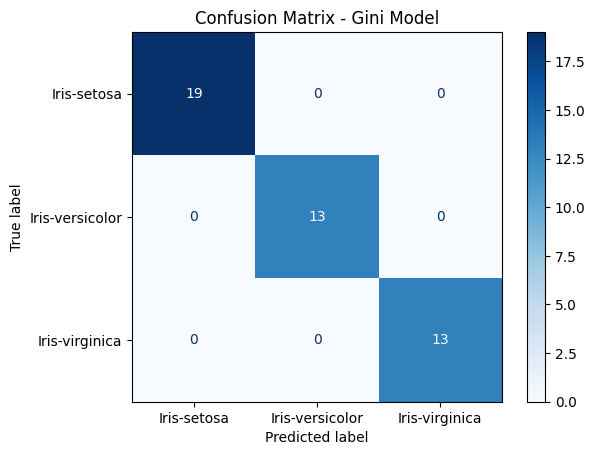


Metrics for Entropy Model:
{'Accuracy': 0.9777777777777777, 'Precision': np.float64(0.9793650793650793), 'Sensitivity_recall': np.float64(0.9777777777777777), 'Specificity': np.float64(0.9895833333333334), 'F1_score': np.float64(0.9777448559670783)}


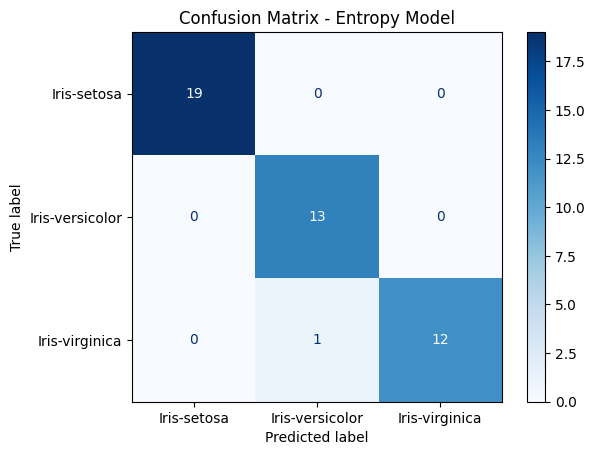

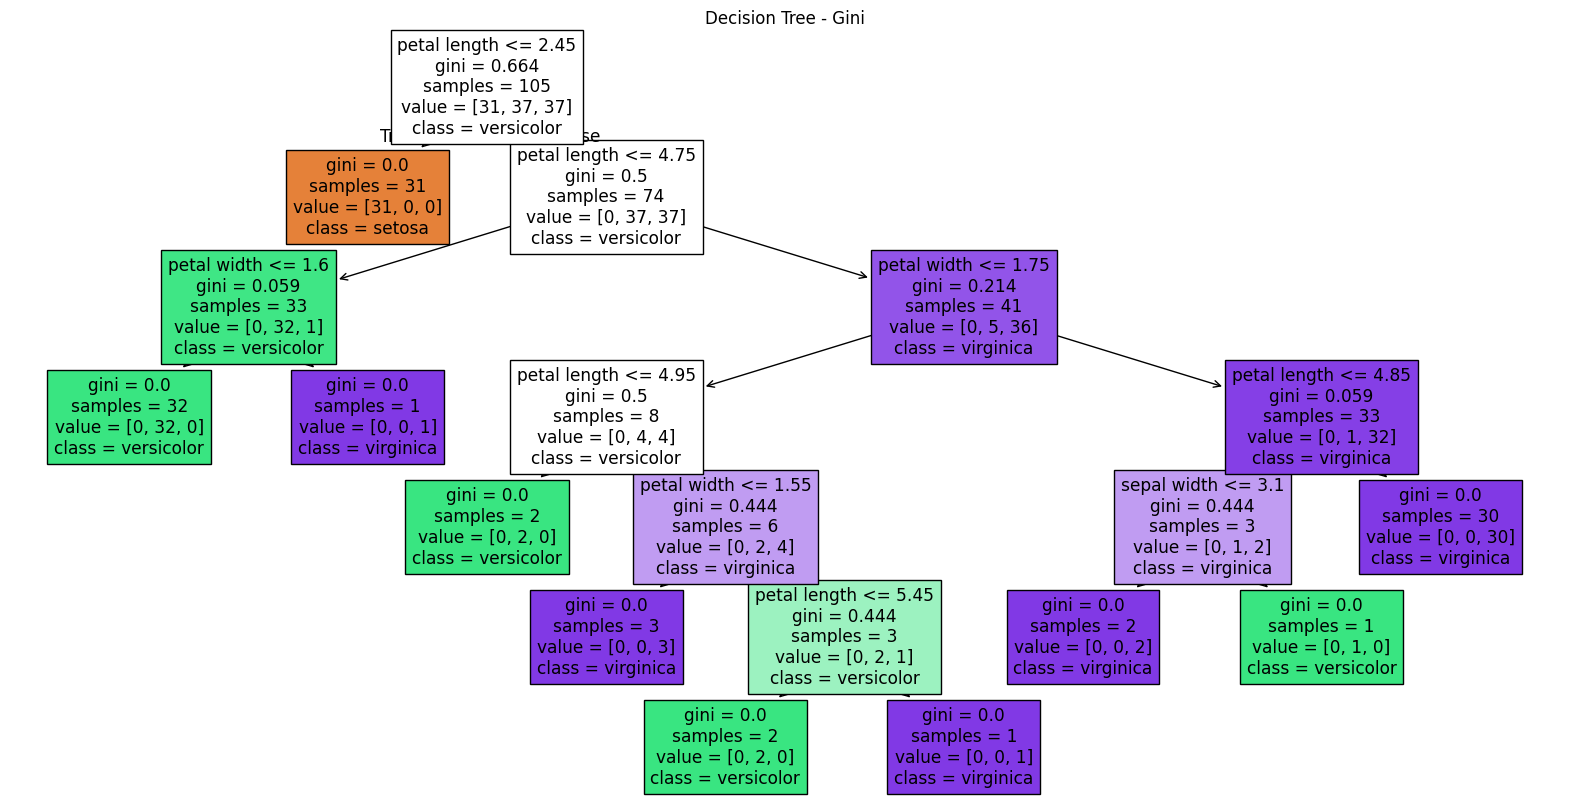

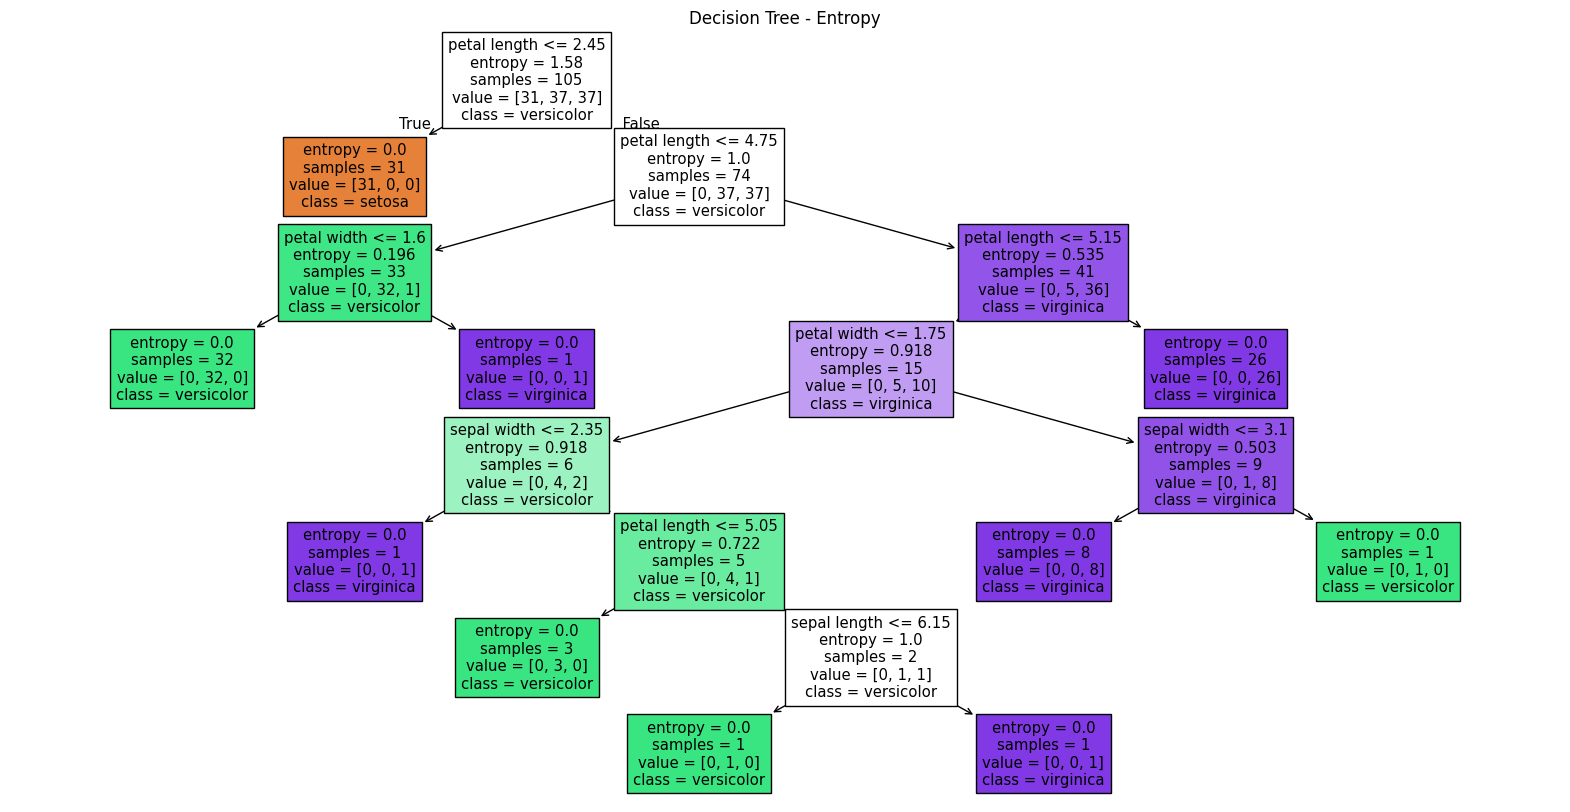

In [30]:
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

def calculate_and_display_metrics(observation, answer, model_name):
    # Calculate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(observation, answer)
    
    # Menghitung Akurasi
    Accuracy = metrics.accuracy_score(observation, answer)
    
    # Menghitung Presisi
    Precision = metrics.precision_score(observation, answer, average='weighted')
    
    # Menghitung Sensitivitas (Recall)
    Sensitivity_recall = metrics.recall_score(observation, answer, average='weighted')
    
    # Menghitung Spesifisitas
    # Untuk multi-class, kita perlu menghitung ini secara manual
    tn = confusion_matrix.sum() - (confusion_matrix.sum(axis=0) + confusion_matrix.sum(axis=1) - np.diag(confusion_matrix))
    fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    Specificity = tn / (tn + fp)
    Specificity = np.mean(Specificity)  # Rata-rata spesifisitas untuk semua kelas
    
    # Menghitung F-Score
    F1_score = metrics.f1_score(observation, answer, average='weighted')
    
    print(f"\nMetrics for {model_name}:")
    print({"Accuracy": Accuracy, "Precision": Precision, "Sensitivity_recall": Sensitivity_recall, 
           "Specificity": Specificity, "F1_score": F1_score})
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dt_gini.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Menghitung dan menampilkan metrik untuk model Gini
calculate_and_display_metrics(y_test, y_pred_gini, "Gini Model")

# Menghitung dan menampilkan metrik untuk model Entropy
calculate_and_display_metrics(y_test, y_pred_entropy, "Entropy Model")

# Visualisasi Decision Tree (Gini)
plt.figure(figsize=(20,10))
plot_tree(dt_gini, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['setosa', 'versicolor', 'virginica'])
plt.title("Decision Tree - Gini")
plt.show()

# Visualisasi Decision Tree (Entropy)
plt.figure(figsize=(20,10))
plot_tree(dt_entropy, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['setosa', 'versicolor', 'virginica'])
plt.title("Decision Tree - Entropy")
plt.show()

In [31]:
df.to_csv('iris.csv', index=False)